import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

pd.set_option('display.max_columns', 50)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set_theme(style='darkgrid')

from models import MLP, ConvNet, LSTM
from train_test import train, test, output_to_accu, output_to_loss
from helpers import RSI, pred_to_perf, perf_to_stat, performance_plot, \
                    turnover, annual_alpha_plot_grossnet, annual_alpha_plot, correlation, \
                    pred_to_daily_ret, price_to_perf

# Data

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [26]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, RSI

In [16]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

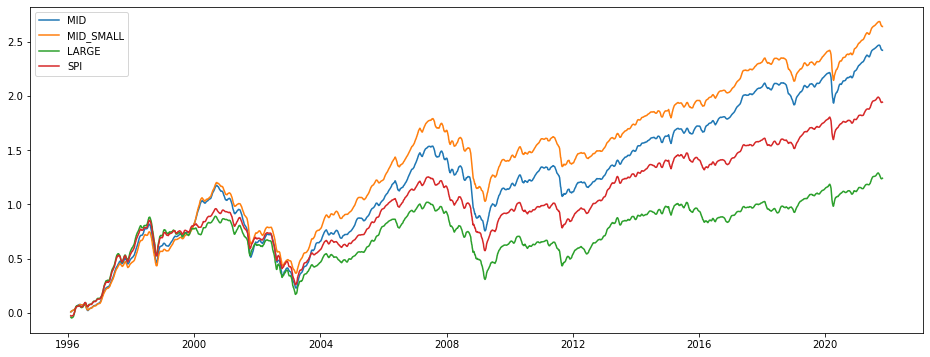

In [4]:
fig, ax = plt.subplots(figsize=(16,6))
data_plot = (pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).cumprod().rolling(20).mean()
sns.lineplot(data=np.log(data_plot), dashes=False)
plt.show()

In [108]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_path = 'data/prices.csv'
indices_price_excel = pd.read_csv(data_path, index_col=0, parse_dates=True)
indices_price_excel.drop(columns=['SMIMC Index'], inplace=True)
indices_price_excel.head()
indices_price_excel.columns = ['SPI', 'MID', 'MID_SMALL', 'LARGE']

bench_price = indices_price_excel['SPI']
price = indices_price_excel[indices_price_excel.columns[1:]].shift(1)

mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

df_dict = {}
df_input = pd.DataFrame()
for col in price.columns:

    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                        mom12[col], mom6[col], mom1[col],
                        vol12[col], vol6[col], vol1[col],
                        RSI14[col], RSI9[col], RSI3[col], MACD[col]], axis=1).iloc[300:]

    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                    'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD']
    
    df_dict[col] = df_temp

df_input = pd.concat(df_dict, axis=1)

In [ ]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [146]:
window = 3
df = pd.DataFrame()
df['price_diff'] = price['MID'].diff()
df['gain'] = df.price_diff.mask(df.price_diff < 0, 0.)
df['loss'] = - df.price_diff.mask(df.price_diff > 0, -0.)
df['avg_gain'] = df.gain.rolling(window=window).mean()
df['avg_loss'] = df.loss.rolling(window=window).mean()
df['rs'] = df.avg_gain.divide(df.avg_loss)
df['rsi'] = 1 - 1 / (1 + df.rs)

In [147]:
df[df.isna().any(axis=1)]

price_diff   gain  loss  avg_gain  avg_loss  rs  rsi
1996-01-04         NaN    NaN   NaN       NaN       NaN NaN  NaN
1996-01-05         NaN    NaN   NaN       NaN       NaN NaN  NaN
1996-01-08        5.53   5.53   0.0       NaN       NaN NaN  NaN
1996-01-09       17.10  17.10   0.0       NaN       NaN NaN  NaN
2001-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2002-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2003-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2003-12-29        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2004-01-05        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2007-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2008-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2008-12-29        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2009-01-05        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2012-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2013-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2013-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2014-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2014-12-29        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2015-01-05        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2017-12-20        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2018-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2019-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2019-12-27        0.00   0.00  -0.0       0.0       0.0 NaN  NaN
2020-01-03        0.00   0.00  -0.0       0.0       0.0 NaN  NaN

In [122]:
rs.head(20)

MID  MID_SMALL     LARGE
1996-01-04        NaN        NaN       NaN
1996-01-05        NaN        NaN       NaN
1996-01-08        NaN        NaN       NaN
1996-01-09        NaN        NaN       NaN
1996-01-10        inf        inf  0.000000
1996-01-11   2.523077   2.149780  0.000000
1996-01-12   0.316757   0.371495  0.000000
1996-01-15   0.510270   0.530374  0.113695
1996-01-16   0.439888   0.564677  0.098105
1996-01-17   0.903814   1.203980  0.503390
1996-01-18   0.118989   0.228856  0.221164
1996-01-19  25.000000        inf  1.673239
1996-01-22  60.095238        inf  0.957711
1996-01-23   4.459364   7.290323  4.873418
1996-01-24   0.777974   0.960199  0.000000
1996-01-25   0.244934   0.059701  0.067449
1996-01-26   1.512911   0.982353  0.056098
1996-01-29   1.355415   1.237037  0.076923
1996-01-30   0.888401   1.099291  0.227425
1996-01-31   0.683656   1.056738  2.292929

In [120]:
rs.iloc[5:].isna().any()

MID          True
MID_SMALL    True
LARGE        True
dtype: bool

In [116]:
price_diff.iloc[2:].isna().any()

MID          False
MID_SMALL    False
LARGE        False
dtype: bool

In [76]:
test = df_input[[('MID', 'MACD'), ('MID', 'ema_12'), ('MID', 'ema_26')]]
test.columns = test.columns.get_level_values(1)
test.head()

MACD       ema_12       ema_26
1996-12-24  0.726971  2247.132355  2213.702329
1996-12-25  0.762014  2248.755563  2215.091397
1996-12-26  0.282759  2250.083643  2216.434903
1996-12-27  1.000000  2251.170253  2217.734342
1996-12-30  1.000000  2253.944752  2219.331224

In [109]:
test2 = test[test.isna().any(axis=1)]

In [7]:
models_list = ['MLP', 'ConvNet', 'LSTM']
# models_list = ['MLP', 'ConvNet']

df_pred_dict = {}
df_prob_dict = {}

threshold = 0.6
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'M'
input_period_days = 15
input_period_weeks = 8

if rebalance_freq == 'M':
    input_period = input_period_weeks
else:
    input_period = input_period_days

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], \
    df_prob_dict[model_name] = backtest_strat(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                              model_name=model_name, nb_epochs=nb_epochs, 
                                              nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                              batch_size=batch_size, verbose=verbose, 
                                              training_window=training_window, threshold=threshold)

    if i == 0:
        df_prob_dict['Ensemble'] = df_prob_dict[model_name].copy()
    else:
        df_prob_dict['Ensemble'] += df_prob_dict[model_name]

df_prob_dict['Ensemble'] /= len(models_list)
df_pred_dict['Ensemble'] = pd.DataFrame().reindex_like(df_prob_dict['Ensemble']).fillna(0)
cols = df_pred_dict['Ensemble'].columns
for k in range(0, len(df_pred_dict['Ensemble'])):
    if k == 0:
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
    else:
        out = df_prob_dict['Ensemble'].iloc[k].max()
        pred_index = df_prob_dict['Ensemble'].iloc[k].argmax()
        if out > threshold:
            df_pred_dict['Ensemble'].iloc[k][cols[pred_index]] = 1
        else:
            df_pred_dict['Ensemble'].iloc[k] = df_pred_dict['Ensemble'].iloc[k-1]

  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model MLP


  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model ConvNet


  0%|          | 0/40 [00:00<?, ?it/s]

Backtesting model LSTM


100%|██████████| 40/40 [00:10<00:00,  3.83it/s]


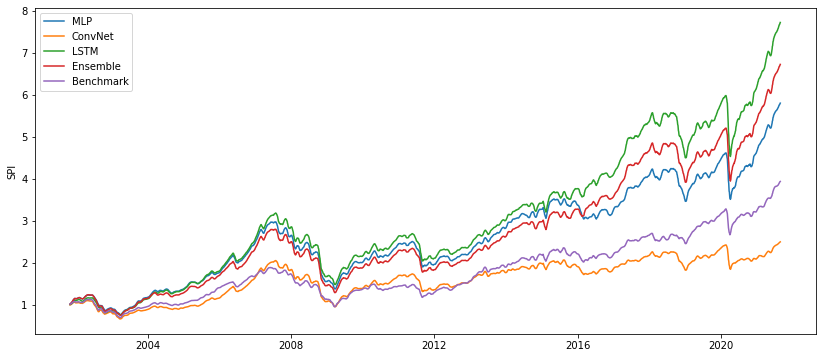

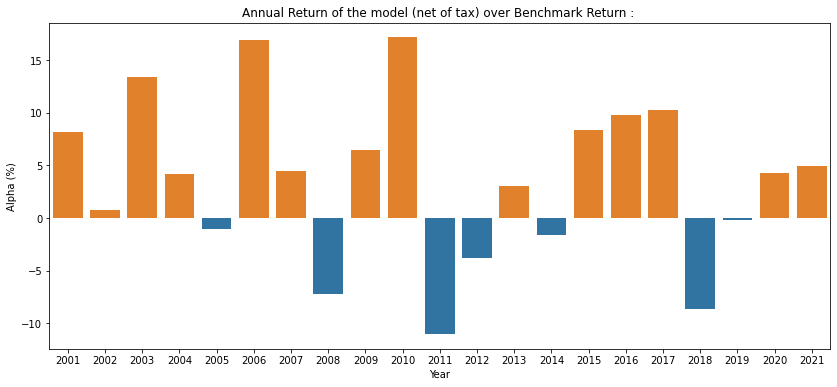

Gross avg. annual return (%)  Net avg. annual return (%)  Avg. annual vol. (%)  Avg Sharpe ratio  Max. Drawdown (%)  Turnover
Benchmark SPI                          8.18                        8.18                 17.12              0.48              44.52         0
MLP                                   11.30                       11.14                 14.94              0.75              47.72        25
ConvNet                                6.73                        6.68                 16.55              0.40              47.72         7
LSTM                                  12.64                       12.64                 14.31              0.88              47.72         0
Ensemble                              11.92                       11.91                 15.09              0.79              47.79         1

In [11]:
df_resume = resume_backtest(df_pred_dict, bench_price, price)
perf_bench = price_to_perf(bench_price.loc[df_pred_dict['Ensemble'].index[0]:df_pred_dict['Ensemble'].index[-1]], log=False)
performance_plot(df_pred_dict, daily_returns, bench_price)
annual_alpha_plot(perf_bench, df_pred_dict['Ensemble'], daily_returns)
display(df_resume)

In [17]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

MLP  ConvNet  LSTM
MLP      1.00     0.47  0.51
ConvNet  0.47     1.00  0.57
LSTM     0.51     0.57  1.00

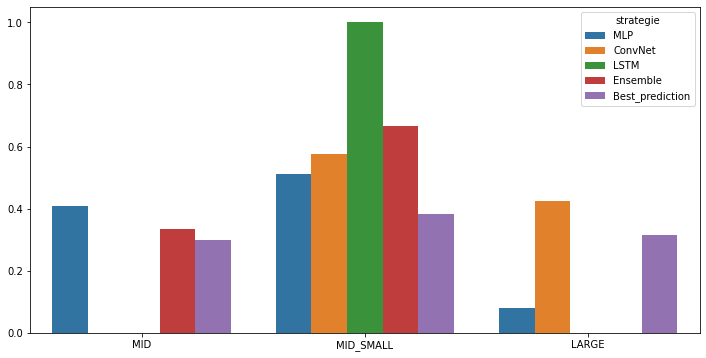

In [18]:
df_results = pd.DataFrame()

for model_name in df_pred_dict:
    L = len(df_pred_dict[model_name])
    df_results = pd.concat([df_results, (df_pred_dict[model_name].sum(axis=0) / L).rename(model_name)], axis=1)

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]]

df_results = pd.concat([df_results, (best_pred.sum(axis=0) / L).rename('Best_prediction')], axis=1)
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

In [15]:
nb_epochs = 20
model_name = 'MLP'
last_date = price.index[-1]
df_input_all = df_X
verbose = 3
last_date = price.index[-1]
rebalance_freq = 'M'

if rebalance_freq == 'M':
    last_date_train = last_month(last_date - relativedelta(weeks=input_period))
else:
    last_date_train = last_friday(last_date - relativedelta(days=input_period))

num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

# Target data
returns = price[:last_date_train].pct_change().shift(1).resample(rebalance_freq, convention='end').agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

if rebalance_freq == 'M':
    start_date = last_month(last_date_train - relativedelta(years=training_window))
else:
    start_date = last_friday(last_date_train - relativedelta(years=training_window))

if rebalance_freq =='M':
    start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
else:
    start_date_input = start_date - relativedelta(days=input_period)
    start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

df_output = best_pred.loc[start_date:].dropna()
df_input = df_input_all.loc[start_date_input:df_output.index[-1]]

X = []
for idx in df_output.index:
    # If we rebalance monthly, the input data will be weekly data
    if rebalance_freq == 'M':
        dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
        reb_freq_input = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
        df_input_period = df_input.loc[:idx].asfreq(reb_freq_input, method='ffill').iloc[-input_period:]
    # If we rebalance weekly, the input data will be daily data
    else:
        df_input_period = df_input.loc[:idx].iloc[-input_period:]

    X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
    X.append(X_period)
    
X = np.array(X)
y = df_output.values
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

train_mean = X.mean(dim=[0, 1, 2], keepdim=True)
train_std = X.std(dim=[0, 1, 2], keepdim=True)
X = X.sub_(train_mean).div_(train_std)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)
y = y.to(device)

# Initialize ML models only at first iteration
dim1, dim2, dim3 = X.size(1), X.size(2), X.size(3)
if model_name == 'MLP':
    model = MLP(dim1, dim2, dim3)
elif model_name == 'ConvNet':
    model = ConvNet(dim1, dim2, dim3)
elif model_name == 'LSTM':
    model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, device=device)
model.to(device)

train(model, X, y, nb_epochs, batch_size=batch_size, verbose=verbose)

# Today output
if rebalance_freq == 'M':
    dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    reb_freq_input = 'W-' + dayofweek[df_input_all.index[-1].weekday()][:3].upper()
    df_input_period = df_input.loc[:idx].asfreq(reb_freq_input, method='ffill').iloc[-input_period:]
else:
    df_input_period = df_input_all.iloc[-input_period:]

X = df_input_period.values.reshape(input_period, num_tickers, num_features)
X = torch.from_numpy(X).float()
X = X.view(1, X.size(0), X.size(1), X.size(2))
out = model(X)
pd.DataFrame(index=[model_name], columns=price.columns, data=out.cpu().detach().numpy())

100%|██████████| 20/20 [00:00<00:00, 119.55it/s]


MID  MID_SMALL  LARGE
MLP  0.0        1.0    0.0

In [21]:
input_period = 15
batch_size = 10
verbose = 0
training_window = 5
nb_epochs_first = 2
nb_epochs = 1
rebalance_freq = 'W-FRI'

model_name = 'MLP'

first_end_date = '2002-02-01'
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]

prob_output = []
pred_output = []

if rebalance_freq == 'M':
    # The moving window every 6 month
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
else:
    # The moving window every 26 weeks
    all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index

for i, end_date in enumerate(tqdm(all_end_dates)):

    start_date = end_date - relativedelta(years=training_window)

    # The first date input must before the first date output
    if rebalance_freq =='M':
        # Make sur the input period start the 1st of the month
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
    else:
        start_date_input = start_date - relativedelta(days=input_period)
        # Make sur the input period start a monday
        start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    for idx in df_output.index:
        # If we rebalance monthly, the input data will be weekly data
        if rebalance_freq == 'M':
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        # If we rebalance weekly, the input data will be daily data
        else:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]

        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)

    X = np.array(X)
    y = df_output.values

    # Find the first prediction date
    if i == 0:
        if rebalance_freq == 'M':
            first_start_date_test = end_date - relativedelta(months=5)
        else:
            first_start_date_test = end_date - relativedelta(weeks=25)

    if rebalance_freq == 'M':
        start_date_test = (end_date - relativedelta(months=5))
        # Make sur the first test date is the end of the month
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
    else:
        start_date_test = end_date - relativedelta(weeks=25)
        # Make sur the first test date is a friday
        delta_days = 4 - start_date_test.weekday()
        if delta_days < 0:
            delta_days += 7
        start_date_test = start_date_test + relativedelta(days=delta_days)
        split_index = df_output.index.get_loc(start_date_test)  

    # Create train and test set
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Transform Numpy arrays to Torch tensors
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    # Standardize data within each feature 
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)


    # Initialize ML models only at first iteration
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                         hidden_size=hidden_size, num_layers=num_layers)

    # More epochs needed for the first iteration 
    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs

    # Train the model
    train(model, X_train, y_train, X_test, y_test, nb_epochs_all, i, batch_size=batch_size, verbose=verbose)

    # Get predictions
    prob, pred = test(model, X_test, y_test)
    pred_output.append(pred)
    prob_output.append(prob)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

return df_pred, df_prob

100%|██████████| 40/40 [00:04<00:00,  8.84it/s]
